# Importing neceesary libraries

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

# Loading dataset

In [48]:
tumor_data = pd.read_csv('../input/brain-tumor/kaggle_3m/data.csv')
tumor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [49]:
## Head of dataset
tumor_data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


# Loading images and fix path

In [50]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/brain-tumor/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/brain-tumor/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/brain-tumor/kaggle_3m/data.csv'


In [51]:
Main_df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
Main_df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...
1,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...
2,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...
3,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...
4,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...


In [52]:
df_imgs = Main_df[~Main_df['path'].str.contains("mask")]
df_masks = Main_df[Main_df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]) if x[BASE_LEN:-END_IMG_LEN] else 0)
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]) if x[BASE_LEN:-END_MASK_LEN] else 0)


# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/brain-tumor/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_2.tif 
Path to the Mask: /kaggle/input/brain-tumor/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_22_mask.tif


### create final datset

In [53]:
brain_dataframe = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_dataframe['mask'] = brain_dataframe['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_dataframe

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,0
1,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,0
2,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,1
3,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,1
4,TCGA_DU_7010_19860307,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_70...,1
...,...,...,...,...
3558,TCGA_DU_7306_19930512,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,0
3559,TCGA_DU_7306_19930512,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,0
3560,TCGA_DU_7306_19930512,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,0
3561,TCGA_DU_7306_19930512,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,0


#  Data Visualization

In [54]:
brain_dataframe['mask'].value_counts()

0    2334
1    1229
Name: mask, dtype: int64

In [55]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_dataframe['mask'].value_counts().index, 
                        y=brain_dataframe['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(3, 190, 252)', marker_line_color='rgb(127, 3, 252)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Plot for Mask Count",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

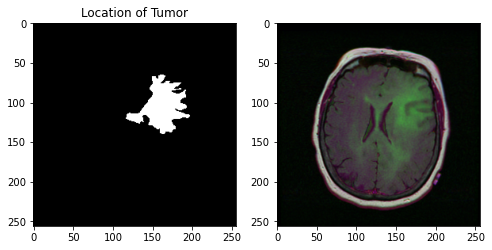

In [56]:
for i in range(len(brain_dataframe)):
    if cv2.imread(brain_dataframe.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_dataframe.mask_path[i]));
plt.title('Location of Tumor')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_dataframe.image_path[i]));

In [57]:
cv2.imread(brain_dataframe.mask_path[i]).max(), cv2.imread(brain_dataframe.mask_path[i]).min()

(255, 0)

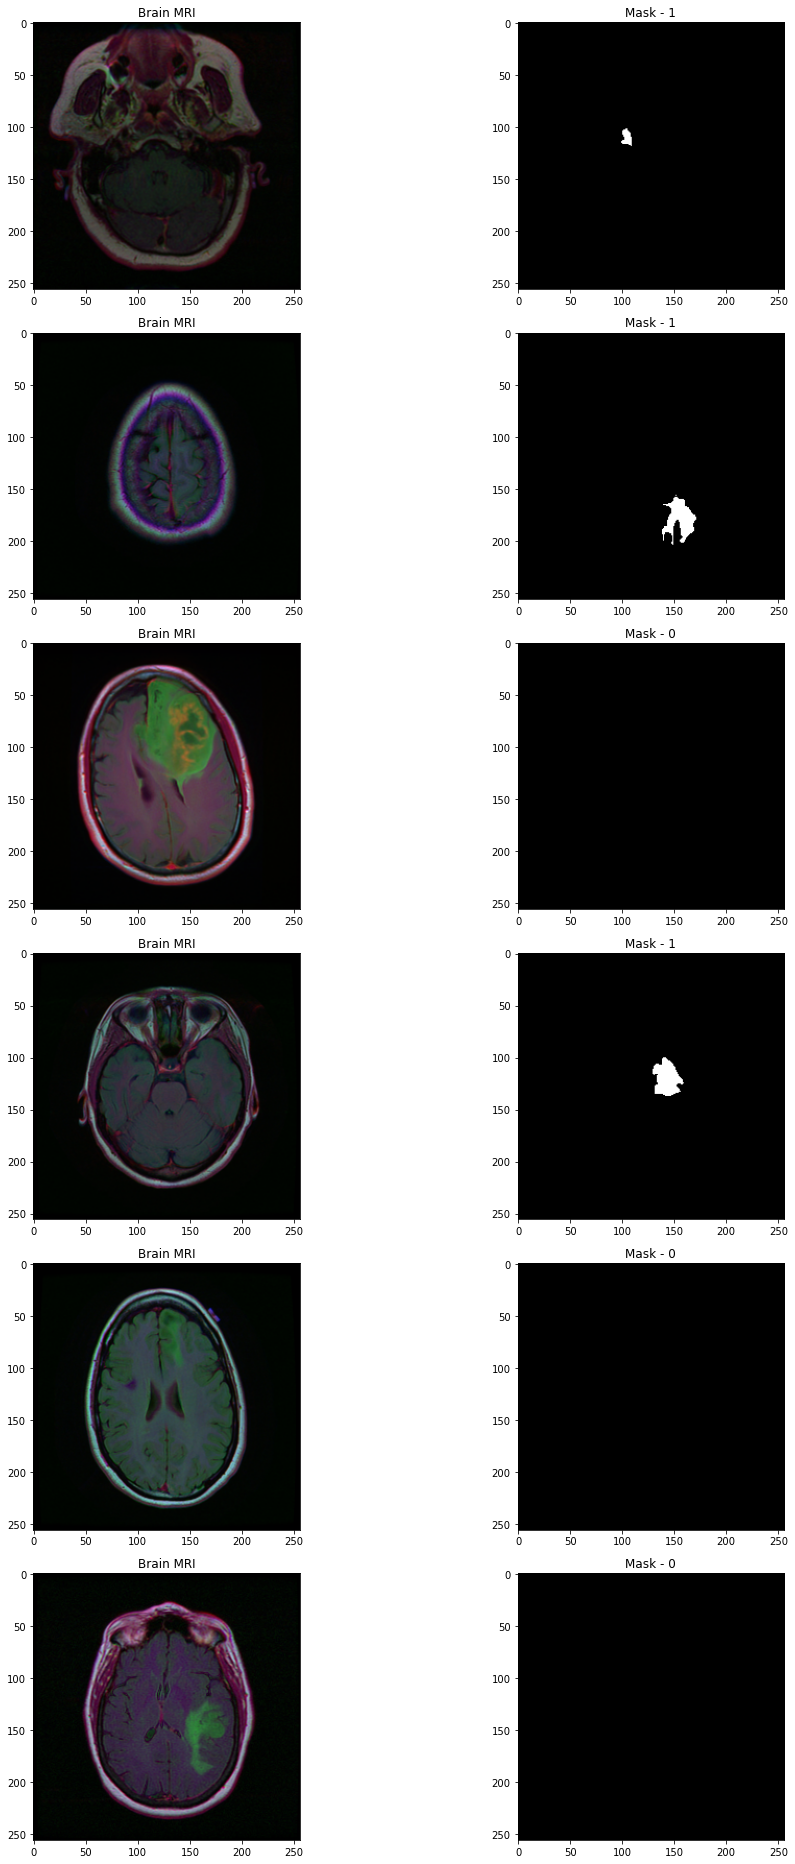

In [58]:
fig, axs = plt.subplots(6, 2, figsize=(16, 26))
counter = 0

for x in range(6):
    random_index = random.randint(0, len(brain_dataframe))
    axs[counter][0].set_title("Brain MRI")
    axs[counter][0].imshow(cv2.imread(brain_dataframe.image_path[random_index]))
    axs[counter][1].set_title("Mask - " + str(brain_dataframe['mask'][random_index]))
    axs[counter][1].imshow(cv2.imread(brain_dataframe.mask_path[random_index]))
    counter += 1

fig.tight_layout()
plt.show()

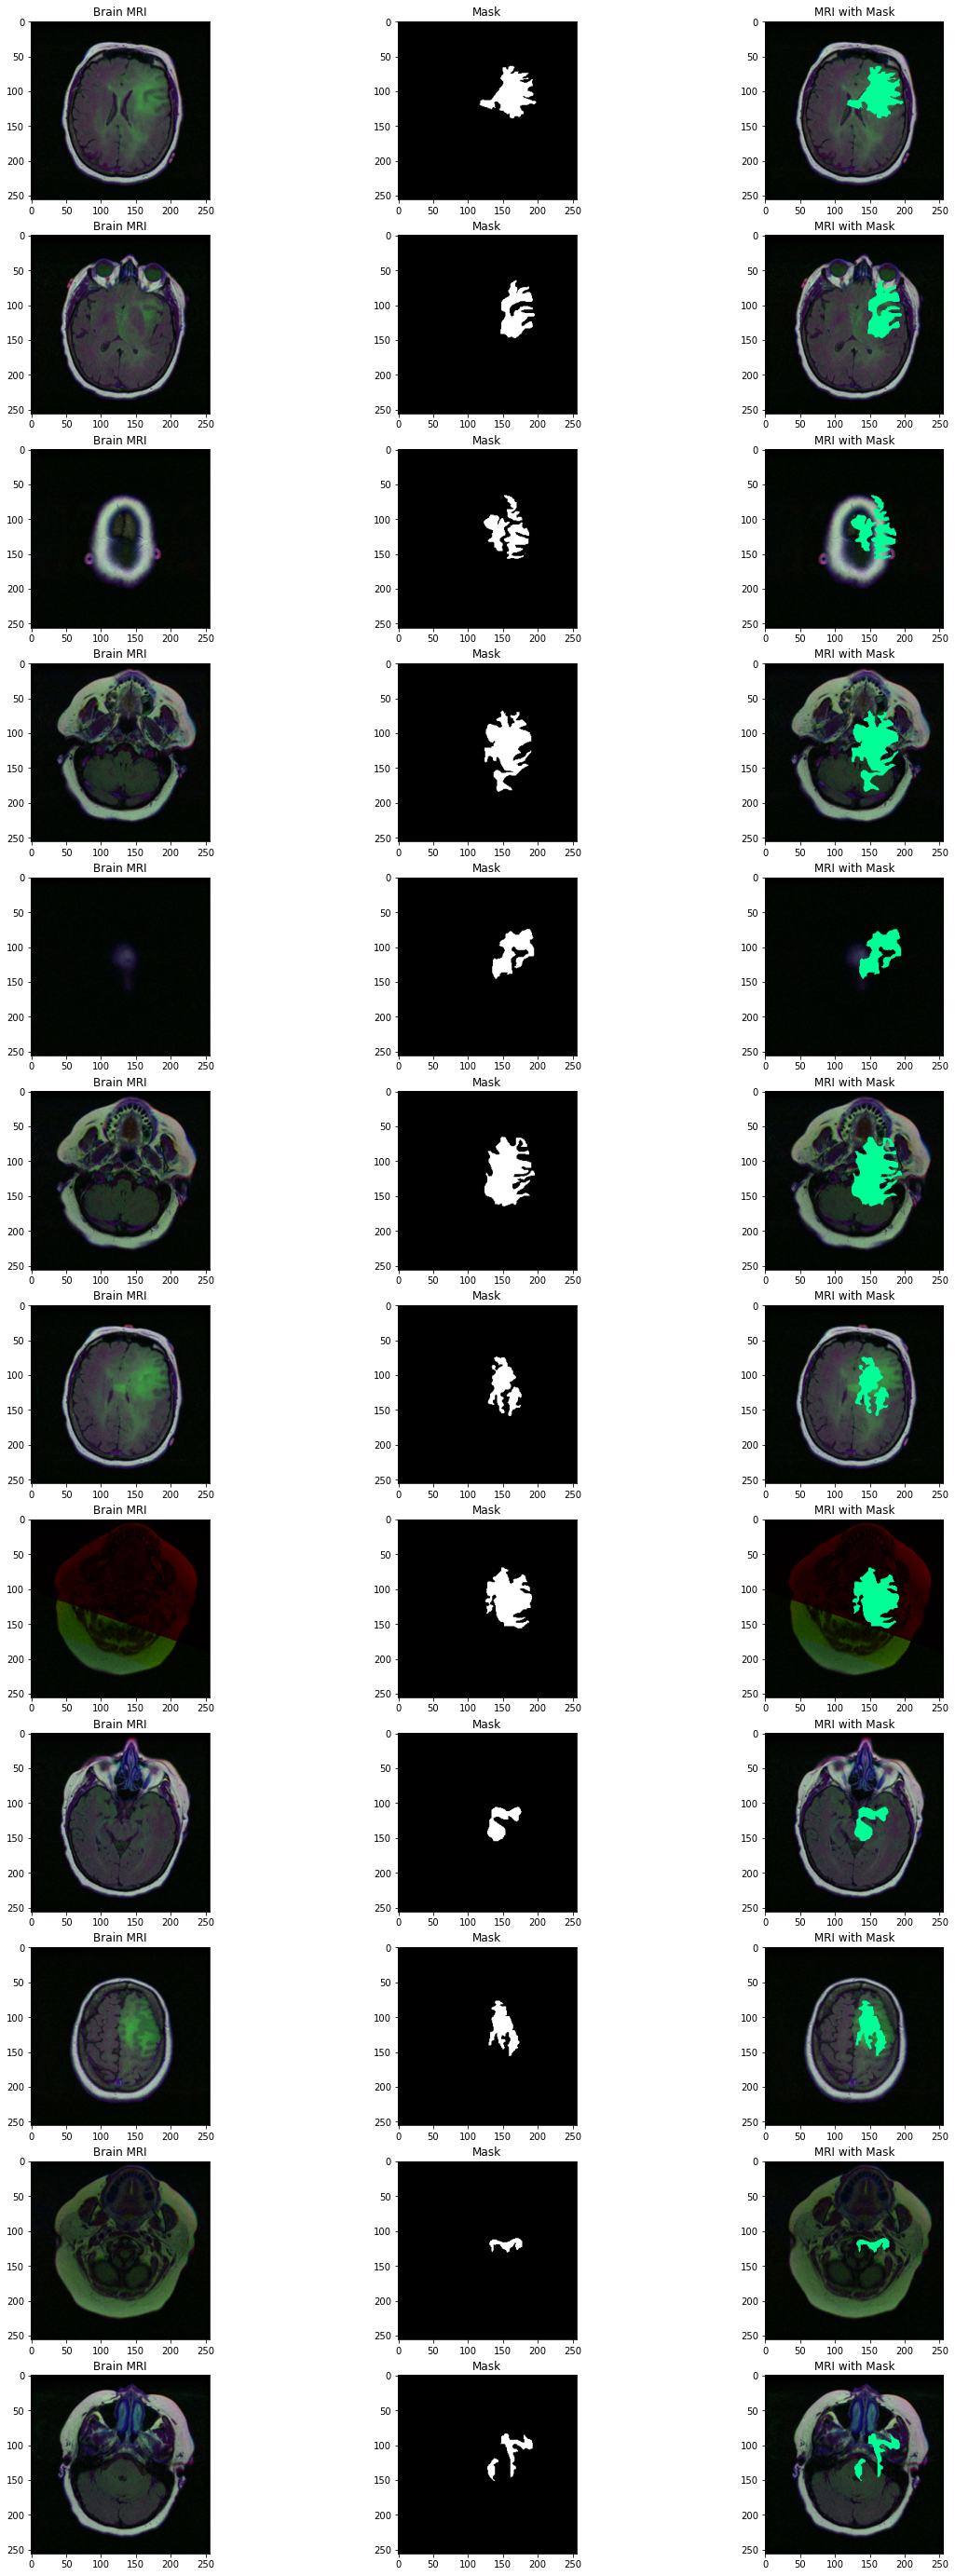

In [59]:
counter = 0
index = 0
fig, axs = plt.subplots(12, 3, figsize=(20, 50))

for mask in brain_dataframe['mask']:
    if mask == 1:
        brain_mri = io.imread(brain_dataframe.image_path[index])
        axs[counter][0].set_title("Brain MRI")
        axs[counter][0].imshow(brain_mri)
        
        mask = io.imread(brain_dataframe.mask_path[index])
        axs[counter][1].set_title("Mask")
        axs[counter][1].imshow(mask, cmap='gray')

        brain_mri[mask == 255] = (0, 255, 150)
        axs[counter][2].set_title("MRI with Mask")
        axs[counter][2].imshow(brain_mri)
        counter += 1
    index += 1
    if counter == 12:
        break
    


# Split the dataset for Test, Train & validation set

In [60]:
brain_train_df = brain_dataframe.drop("patient_id", axis=1)
brain_train_df["mask"] = brain_train_df["mask"].astype(str)
brain_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563 entries, 0 to 3562
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3563 non-null   object
 1   mask_path   3563 non-null   object
 2   mask        3563 non-null   object
dtypes: object(3)
memory usage: 83.6+ KB


In [61]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_train_df, test_size=0.15)

In [62]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 2726 validated image filenames belonging to 2 classes.
Found 302 validated image filenames belonging to 2 classes.
Found 535 validated image filenames belonging to 2 classes.


# Train a classifier model to determine whether the tumor exist or not

In [63]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
model.summary()

94773248/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [64]:
# before this i tried with trainable layer but the accuracy was less as compared
classifier_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [65]:
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model


head = classifier_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(classifier_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [66]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [67]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/50
170/170 [==============================] - ETA: 0s - loss: 0.9000 - accuracy: 0.6306
Epoch 00001: val_loss improved from inf to 0.81450, saving model to clf-resnet-weights.hdf5
170/170 [==============================] - 26s 153ms/step - loss: 0.9000 - accuracy: 0.6306 - val_loss: 0.8145 - val_accuracy: 0.6562
Epoch 2/50
170/170 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6598
Epoch 00002: val_loss did not improve from 0.81450
170/170 [==============================] - 23s 134ms/step - loss: 0.6594 - accuracy: 0.6598 - val_loss: 2.0057 - val_accuracy: 0.6736
Epoch 3/50
170/170 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.6646
Epoch 00003: val_loss improved from 0.81450 to 0.65654, saving model to clf-resnet-weights.hdf5
170/170 [==============================] - 23s 138ms/step - loss: 0.6475 - accuracy: 0.6646 - val_loss: 0.6565 - val_accuracy: 0.6771
Epoch 4/50
170/170 [==============================] - ETA: 0s - loss: 0

# Classification Model Evaluation

In [68]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

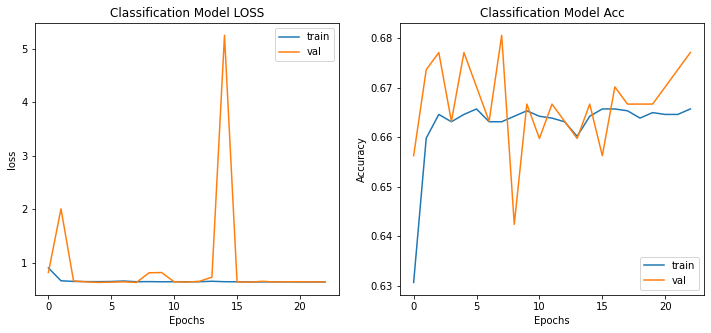

In [69]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [70]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

34/34 [==============================] - 3s 94ms/step - loss: 0.6933 - accuracy: 0.5869
Test accuracy : 58.691591024398804 %


0.5869158878504673
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       314
           1       0.50      0.01      0.02       221

    accuracy                           0.59       535
   macro avg       0.54      0.50      0.38       535
weighted avg       0.55      0.59      0.44       535



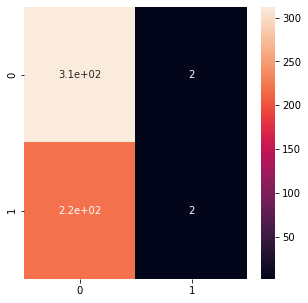

In [71]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

# Building a Tumor Detection Segmentation Model

In [72]:
brain_df_mask = brain_dataframe[brain_dataframe ['mask'] == 1]
brain_df_mask.shape

(1229, 4)

In [73]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1044, valid size is 93 & test size is 92


In [74]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

![alt text](https://drive.google.com/uc?id=10XpINWmLDApPhIjxq_o8aTbeRjXIQRTD)

In [75]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [76]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
_______________________________________________________________________________________

In [77]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 256, 256, 16) 64          conv2d_54[0][0]                  
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_52[0][0]     
_______________________________________________________________________________________

# 9: TRAINING SEGMENTATION MODEL

In [78]:
# Define a custom loss function for ResUNet model

from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [79]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [80]:
h = seg_model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
65/65 [==============================] - ETA: 0s - loss: 0.8863 - tversky: 0.1484
Epoch 00001: val_loss improved from inf to 0.87223, saving model to ResUNet-segModel-weights.hdf5
65/65 [==============================] - 8s 128ms/step - loss: 0.8863 - tversky: 0.1484 - val_loss: 0.8722 - val_tversky: 0.1665
Epoch 2/60
65/65 [==============================] - ETA: 0s - loss: 0.8324 - tversky: 0.2167
Epoch 00002: val_loss improved from 0.87223 to 0.84664, saving model to ResUNet-segModel-weights.hdf5
65/65 [==============================] - 7s 115ms/step - loss: 0.8324 - tversky: 0.2167 - val_loss: 0.8466 - val_tversky: 0.1989
Epoch 3/60
65/65 [==============================] - ETA: 0s - loss: 0.7943 - tversky: 0.2641
Epoch 00003: val_loss improved from 0.84664 to 0.81043, saving model to ResUNet-segModel-weights.hdf5
65/65 [==============================] - 8s 122ms/step - loss: 0.7943 - tversky: 0.2641 - val_loss: 0.8104 - val_tversky: 0.2443
Epoch 4/60
65/65 [==============

In [81]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

# 10: SEGMENTATION MODEL EVALUATION

In [82]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

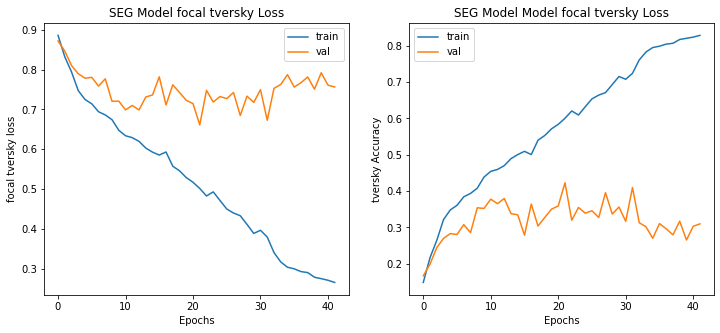

In [83]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model Model focal tversky Loss");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [84]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

5/5 [==============================] - 0s 82ms/step - loss: 0.7071 - tversky: 0.3683
Segmentation tversky is 36.83%


# 11: SEGMENTATION MODEL PREFORMACE 
## (COMBINING CLASSIFICATION AND SEGMENTAION MODEL BUILDING PIPELINE)

In [85]:
def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [86]:
# making prediction
df_pred = prediction(test, model, seg_model)
df_pred

,image_path,predicted_mask,has_mask
0,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_64...,No mask :),0
1,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,No mask :),0
2,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_81...,No mask :),0
3,/kaggle/input/brain-tumor/kaggle_3m/TCGA_HT_81...,No mask :),0
4,/kaggle/input/brain-tumor/kaggle_3m/TCGA_FG_66...,No mask :),0
...,...,...,...
530,/kaggle/input/brain-tumor/kaggle_3m/TCGA_HT_76...,No mask :),0
531,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_64...,No mask :),0
532,/kaggle/input/brain-tumor/kaggle_3m/TCGA_HT_78...,No mask :),0
533,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,No mask :),0


In [87]:
# combining the original and prediction dataframes
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

,image_path,mask_path,mask,predicted_mask,has_mask
0,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_64...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_64...,0,No mask :),0
1,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_73...,0,No mask :),0
2,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_81...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_81...,0,No mask :),0
3,/kaggle/input/brain-tumor/kaggle_3m/TCGA_HT_81...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_HT_81...,0,No mask :),0
4,/kaggle/input/brain-tumor/kaggle_3m/TCGA_FG_66...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_FG_66...,0,No mask :),0
5,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_72...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_72...,0,No mask :),0
6,/kaggle/input/brain-tumor/kaggle_3m/TCGA_CS_49...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_CS_49...,0,No mask :),0
7,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_58...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_58...,0,No mask :),0
8,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_A5...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_DU_A5...,0,No mask :),0
9,/kaggle/input/brain-tumor/kaggle_3m/TCGA_CS_53...,/kaggle/input/brain-tumor/kaggle_3m/TCGA_CS_53...,0,No mask :),0


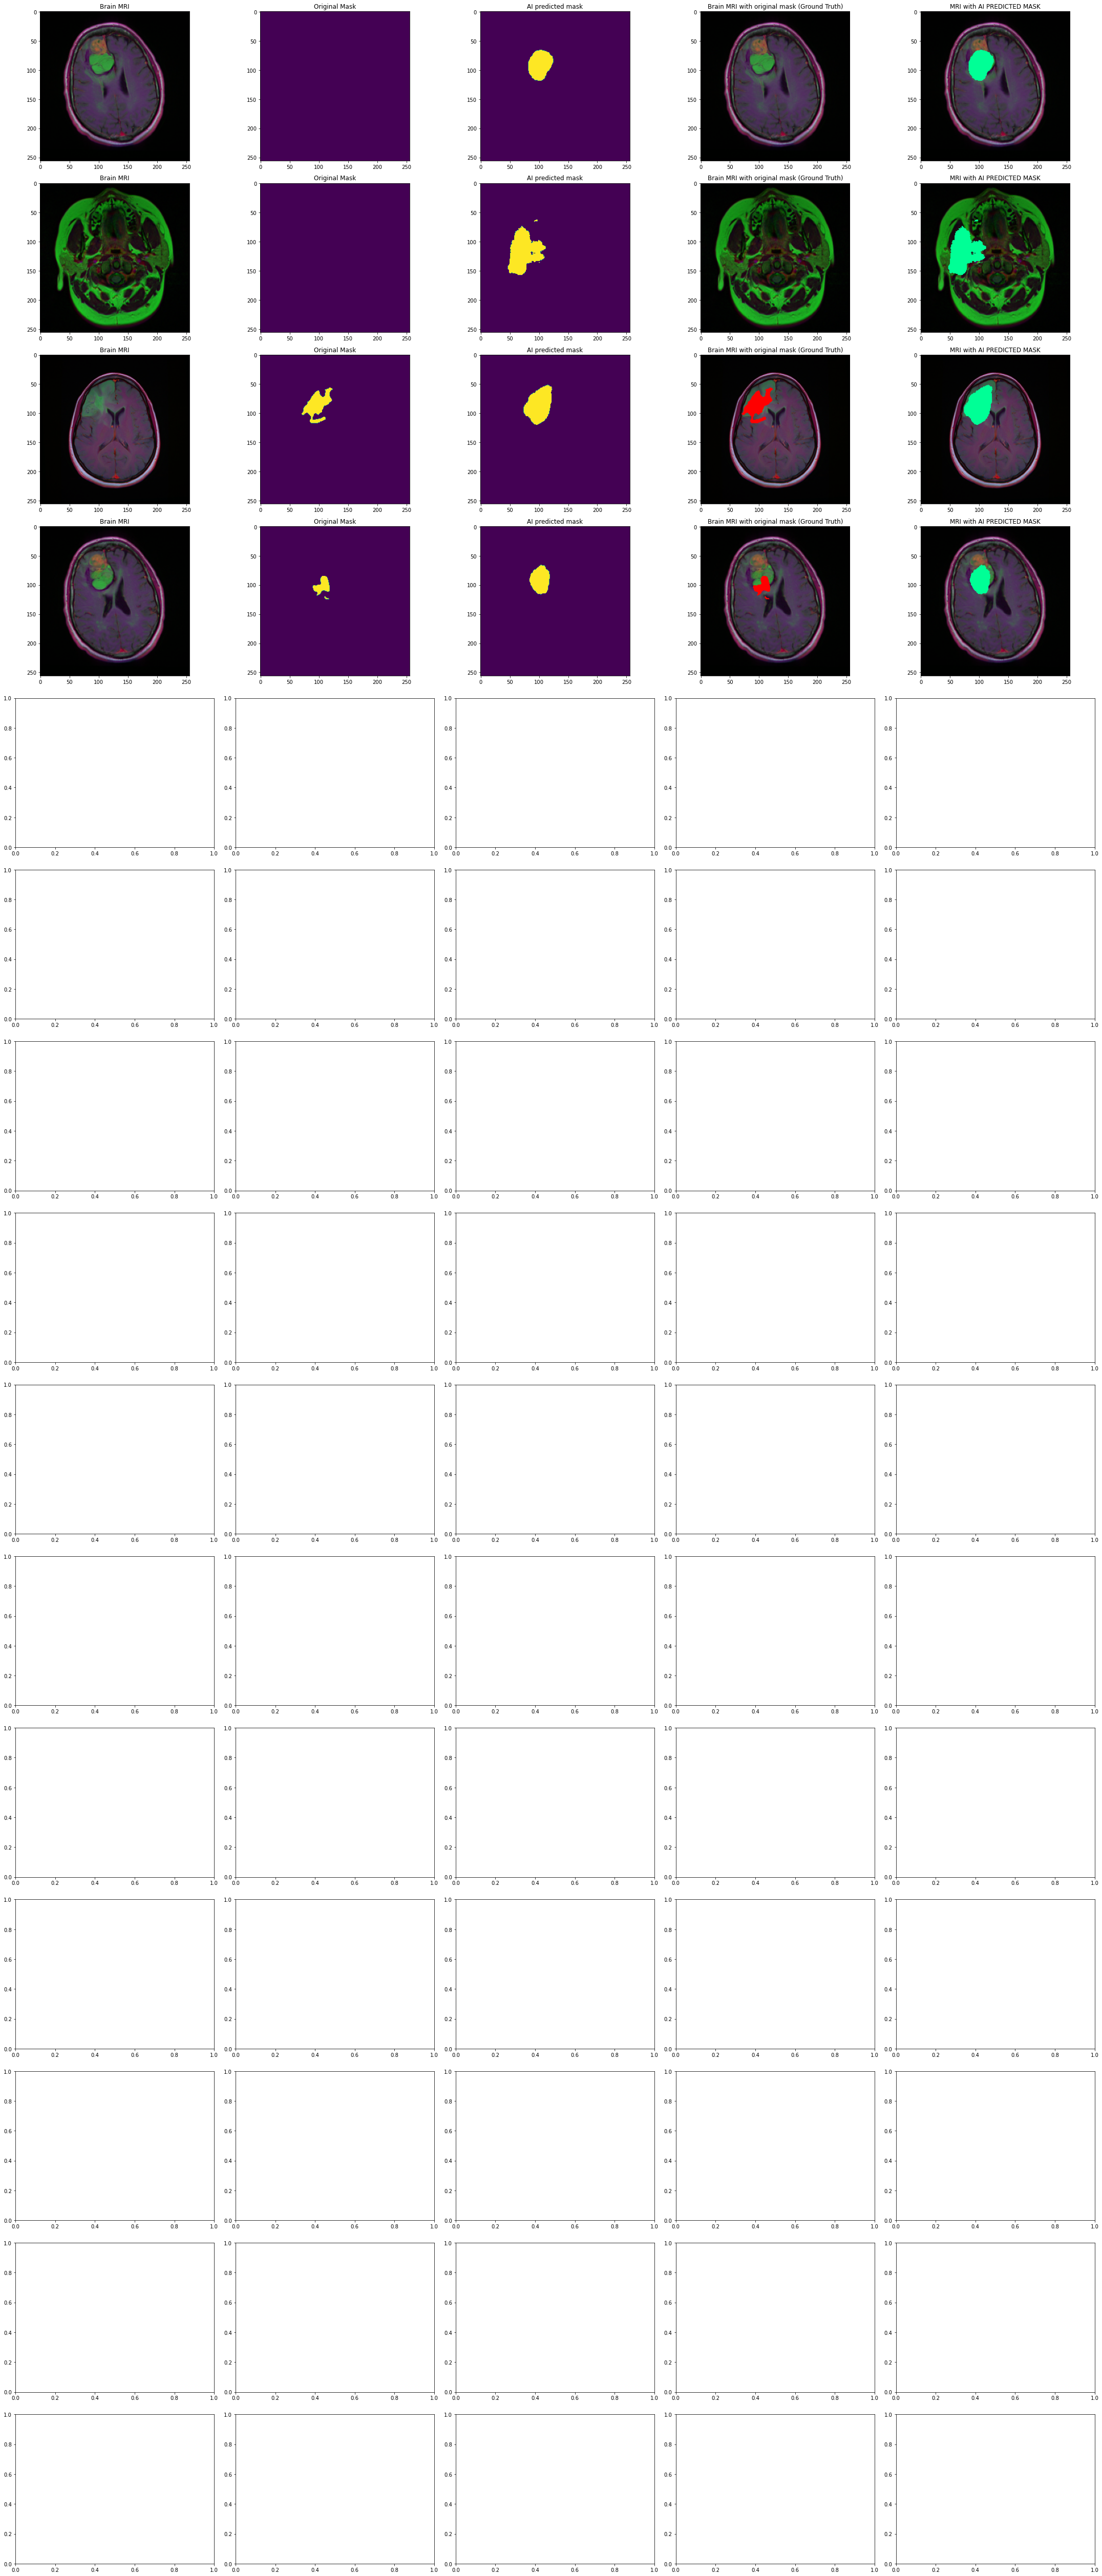

In [88]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        